# Deep Dream:

DeepDream is a computer vision program created by Google engineer Alexander Mordvintsev which uses a convolutional neural network to find and enhance patterns in images via algorithmic pareidolia, thus creating a dream-like hallucinogenic appearance in the deliberately over-processed images

In [1]:
import keras
from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.


### I am using a pretrained convnet i.e an inceptionV3 model to generate my deep dreams

In [12]:
### DISABLE ALL TRAINING ####
K.set_learning_phase(0)

In [13]:
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

# Gradient Ascent:

Gradient ascent is just the process of maximizing, instead of minimizing, a loss function. We will simultaneously maximize the activation of all filters in a number of layers. Specifically, we will maximize a weighted sum of the L2 norm of the activations of a set of high-level layers. 

Low level layers: Capture just color and shapes 
High level layers: Can classify images and Capture more complex nuances (cats and dogs)

Hence maximizing loss in the high level layers can generate more trippy details

In [16]:
## These are the layers that I have chosen
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

## Computing the loss:

We define the loss and sdd the L2 norm of the features of a layer to the loss.

L2 norm: The L2-norm |x| is a vector norm defined for a complex vector



In [17]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling


## Gradient Ascent:

Write a function for Maximizing our loss function 

In [18]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

# Algorithm:

First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than previous one by a factor 1.4 we start by processing a small image and we increasingly upscale it

Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original image should look like at the larger scale

In [19]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


## Execution of the algorithm with the help of the above defined functions

In [20]:
import numpy as np

#### hyperparameters ####

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

#### hyperparameters ####


# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = 'joker.png'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='deepdream.png')


Processing image shape (1102, 1959)
...Loss value at 0 : 1.80568
...Loss value at 1 : 2.2655
...Loss value at 2 : 2.96501
...Loss value at 3 : 3.84937
...Loss value at 4 : 4.80121
...Loss value at 5 : 5.75868
...Loss value at 6 : 6.70323
...Loss value at 7 : 7.63745
...Loss value at 8 : 8.56299
...Loss value at 9 : 9.45468
Processing image shape (1542, 2742)
...Loss value at 0 : 3.77771
...Loss value at 1 : 5.24345
...Loss value at 2 : 6.48007
...Loss value at 3 : 7.60811
...Loss value at 4 : 8.68123
...Loss value at 5 : 9.70621
Processing image shape (2160, 3840)
...Loss value at 0 : 3.76414
...Loss value at 1 : 5.13439
...Loss value at 2 : 6.35017
...Loss value at 3 : 7.49895
...Loss value at 4 : 8.62272
...Loss value at 5 : 9.69051


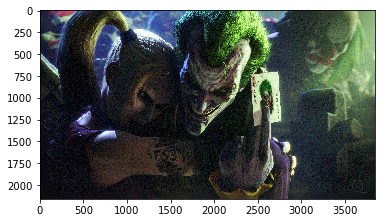

In [6]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("deepdream.png")
plt.imshow(image)
plt.show()

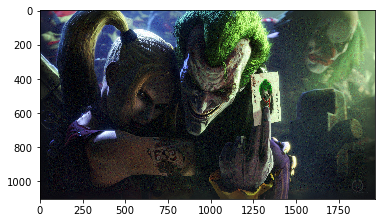

In [5]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("dream_at_scale_(1102, 1959).png")
plt.imshow(image)
plt.show()